In [7]:
## mcl1.ipynb, mcl3.ipynb

In [1]:
import sys                       
sys.path.append('../script/')
from robot import *
from scipy.stats import multivariate_normal
import random #追加
import copy

In [2]:
class Particle:
    def __init__(self, init_pose):
        self.pose = init_pose
        
    def motion_update(self, time, nu, omega, noise_rate_pdf):
        ns = noise_rate_pdf.rvs()
        noised_nu = nu + ns[0]*math.sqrt(abs(nu)/time) + ns[1]*math.sqrt(abs(omega)/time)
        noised_omega = omega + ns[2]*math.sqrt(abs(nu)/time) +ns[3]*math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(noised_nu, noised_omega, time, self.pose)

In [3]:
class Mcl:  ###Mcl3 (1,2,5行目以降を記載)
    def __init__(self, init_pose, num, motion_noise_stds):
        self.particles = [Particle(init_pose) for i in range(num)]
        
        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2]) # 雑音
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        
    def motion_update(self, time, nu, omega):
        #print(self.motion_noise_rate_pdf.cov)
        for p in self.particles: p.motion_update(time, nu, omega, self.motion_noise_rate_pdf)
        
    def draw(self, ax, elems):   #追加
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles] 
        vys = [math.sin(p.pose[2]) for p in self.particles] 
        elems.append(ax.quiver(xs, ys, vxs, vys, color="blue", alpha=0.2))

In [4]:
class EstimationAgent(Agent):  ###EstimationAgent3 (1,2,6,7行目を記載)
    def __init__(self, time_interval, nu, omega, estimator): 
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def decision(self, observation=None):
        #self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.estimator.motion_update(self.time_interval, self.prev_nu, self.prev_omega, )
        self.prev_nu, self.prev_omega = self.nu, self.omega
        return self.nu, self.omega
        
    def draw(self, ax, elems):   #追加
        self.estimator.draw(ax, elems)

<IPython.core.display.Javascript object>


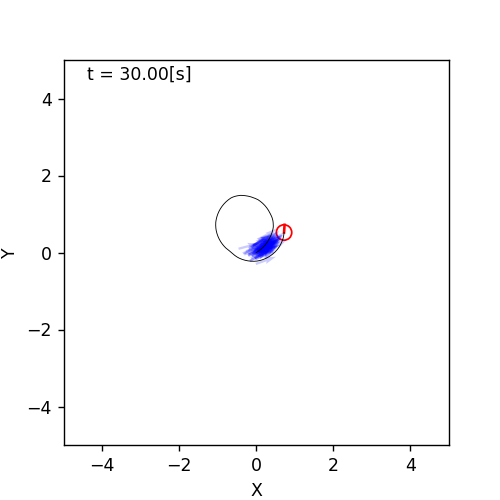

In [5]:
def trial(motion_noise_stds):
    time_interval=0.1
    world = World(30, time_interval)
    initial_pose = np.array([0, 0, math.pi/6]).T
    estimator = Mcl(initial_pose, 100, motion_noise_stds)
    circling = EstimationAgent(time_interval, 0.2, 12.0/180*math.pi, estimator)
    r = Robot(initial_pose, sensor=None, agent=circling, color="red")
    world.append(r)
    
    world.draw()
    
trial({"nn":0.01, "no":0.02, "on":0.03, "oo":0.04})
    

In [13]:
world = World(30, 0.1)  

### 地図を生成して3つランドマークを追加 ###
m = Map()
for ln in [(-2,4), (2,-3), (0,-3)]: m.append_landmark(Landmark(*ln))
world.append(m)          

### ロボットを作る ###
initial_pose = np.array([0, 0, math.pi/6]).T
estimator = Mcl(initial_pose, 100, motion_noise_stds={"nn":0.01, "no":0.02, "on":0.03, "oo":0.04})
circling = EstimationAgent(0.1, 0.2, 12.0/180*math.pi, estimator) 
estimator.motion_update(0.1, 0.2, 12.0/180*math.pi)
for p in estimator.particles:
    print(p.pose)
#r = Robot(initial_pose, sensor=Camera(m), agent=circling) 
#world.append(r)

### アニメーション実行 ###
#world.draw()